### Review loss curves

In [1]:
import pandas as pd

df = pd.read_csv("checkpoints-20230808/logs.txt", header=None, names=['x', 'y', 'train_loss', 'val_loss', 'lr', 't'])
display(df.head(1))

df['train_loss'] = df.train_loss.apply(lambda x: float(x.split(": ")[-1]))
df['val_loss'] = df.val_loss.apply(lambda x: float(x.split(": ")[-1]))
df['lr'] = df.lr.apply(lambda x: float(x.split(": ")[-1]))

,x,y,train_loss,val_loss,lr,t
0,Epoch: 0,Batch: 2000,Train loss: 8.363,Val loss: 6.946,LR: 3e-05,Time: 375.744s


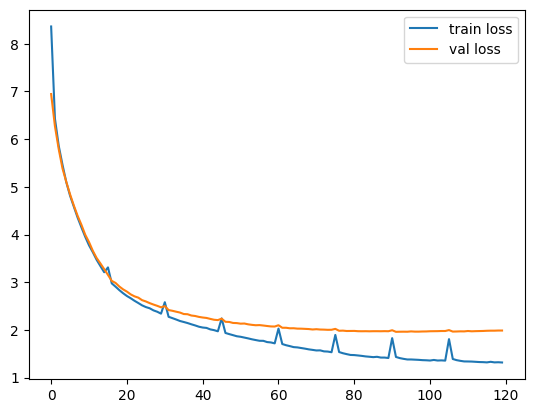

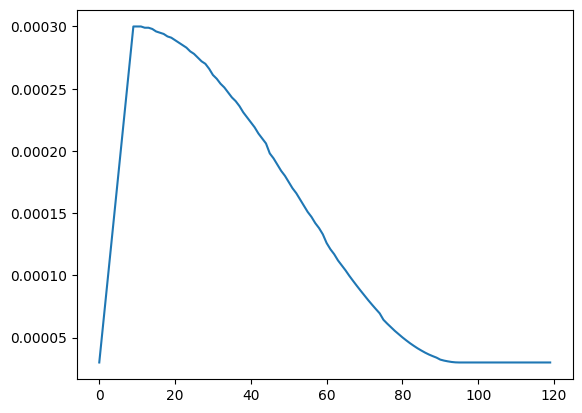

In [2]:
import matplotlib.pyplot as plt
plt.plot(df.train_loss.values)
plt.plot(df.val_loss.values)
plt.legend(["train loss", "val loss"])
plt.show()
plt.plot(df.lr.values)
plt.show()

### Sample translation

In [3]:
import torch
from torch.nn import functional as F
from transformer import Transformer, BOS_IDX, EOS_IDX, block_size, device

In [4]:
model = Transformer()
model.load_state_dict(torch.load('checkpoints-20230808/checkpoint-ep05.pt'))
model.to(device)
model.eval()

Transformer(
  (token_embedding_table): Embedding(30000, 512)
  (token_embedding_table_enc): Embedding(30000, 512)
  (position_embedding): PositionalEncoding()
  (encoder_blocks): Sequential(
    (0): EncoderBlock(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x Head(
            (key): Linear(in_features=512, out_features=64, bias=False)
            (query): Linear(in_features=512, out_features=64, bias=False)
            (value): Linear(in_features=512, out_features=64, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )


In [5]:
from tokenizers import Tokenizer
tokenizers = {}
for lang in ['en', 'es']:
    tokenizers[lang] = Tokenizer.from_file(f"tokenizer-{lang}.json")

In [6]:
def tensor_transform(token_ids):
    transformed =  torch.cat((
        torch.tensor([BOS_IDX]),
        torch.tensor(token_ids),
        torch.tensor([EOS_IDX]))
    )
    if len(transformed.shape) == 1:
        transformed = transformed[None, :]
    return transformed

In [7]:
def generate(model, idx_enc, greedy=False):
    # idx is (B, T) array of indices in the current context
    B = idx_enc.shape[0]
    device = next(model.parameters()).device
    idx = torch.ones(B,1).fill_(BOS_IDX).type(torch.long).to(device)
    for i in range(block_size):
    # for i in range(10):
        # get the predictions
        logits, _ = model(idx, idx_enc)
        # focus only on the last time step
        logits = logits[:, -1, :] # becomes (B, C)
        if greedy:
            idx_next = torch.argmax(logits, dim=-1)
        else:
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
        # make everything comes after 1st EOS an EOS
        idx_next = torch.where(idx[:, -1]==EOS_IDX, EOS_IDX, idx_next.squeeze())
        # append sampled index to the running sequence
        idx = torch.cat((idx, idx_next[:, None]), dim=1) # (B, T+1)
        if torch.all(idx[:, -1]==EOS_IDX):
            break
    return idx

In [8]:
sents = [
    "What a beautiful day!",
    "This is the first deep learning model that I built from scratch.",
    "You'll have to address any questions to my commanding officer.",
    "The results of the project are clear.",
    "I mean, my dad does business with them, or he raised money for them.",
    "A 3-month-old died after he was left unattended in a vehicle in Houston",
]

In [9]:
for sent in sents:
    toks = tensor_transform(tokenizers['en'].encode(sent).ids).to(device)
    toks_es = generate(model, toks, greedy=True)
    sent_es = tokenizers['es'].decode(toks_es[0].tolist())
    print(sent)
    print(sent_es)
    print()

What a beautiful day!
¡ que dia tan bonito!

This is the first deep learning model that I built from scratch.
este es el primer modelo de aprendizaje profundo que construi de rubon.

You'll have to address any questions to my commanding officer.
tendras que resolver cualquier pregunta para mi oficial de mando.

The results of the project are clear.
los resultados del proyecto son claros.

I mean, my dad does business with them, or he raised money for them.
quiero decir, mi padre lo hace con ellos, o el se las arreglo a su dinero.

A 3-month-old died after he was left unattended in a vehicle in Houston
un viejo de 3 meses murio despues de que se fue dejado sin limites en un vehiculo en houston

